# 5. Оказывают ли цены на нефть влияние на объем продаж?

In [1]:
# Загрузка нужных библиотек
import pandas as pd
import numpy as np

import warnings; warnings.simplefilter('ignore')

from IPython.display import Image, display

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import scipy.stats as stats
from scipy.stats.stats import pearsonr

In [2]:
# Загрузка данных
df = pd.read_csv('data/df.csv')

df.date = pd.to_datetime(df.date)
df.head()

,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,month,year
0,2013-01-01,1,Автомобильные товары,0.0,0,Quito,Pichincha,D,13,1,2013
1,2013-01-01,1,Уход за детьми,0.0,0,Quito,Pichincha,D,13,1,2013
2,2013-01-01,1,Косметика,0.0,0,Quito,Pichincha,D,13,1,2013
3,2013-01-01,1,Напитки,0.0,0,Quito,Pichincha,D,13,1,2013
4,2013-01-01,1,Книги,0.0,0,Quito,Pichincha,D,13,1,2013


Для масштабирования данных будем использовать MinMaxScaler.

In [3]:
from sklearn.preprocessing import MinMaxScaler

def scale_series(series):
    scaler = MinMaxScaler()
    scaled_values = scaler.fit_transform(series.values.reshape(-1, 1)).flatten()
    return pd.Series(scaled_values, index=series.index)

Сравним показатели цен на нефть и суммарные продажи. Выделим суммарные значения за каждую неделю и отмасштабируем данные.

In [4]:
oil_prices = pd.read_csv('data/oil.csv', index_col=[0], parse_dates=['date'])['dcoilwtico']
total_sales = df.groupby('date')['sales'].sum()

total_sales_resampled = total_sales.resample('1W').sum().interpolate()
total_sales_resampled = scale_series(total_sales_resampled)
total_sales_resampled = pd.DataFrame(total_sales_resampled).reset_index().rename(columns={0: 'sales'})

oil_prices_resampled = oil_prices.resample('1W').sum().interpolate()
oil_prices_resampled = scale_series(oil_prices_resampled)
oil_prices_resampled = pd.DataFrame(oil_prices_resampled).reset_index().rename(columns={0: 'oil_prices'})

sales_and_prices = total_sales_resampled.merge(oil_prices_resampled, how='left')

Посмотрим на графики.

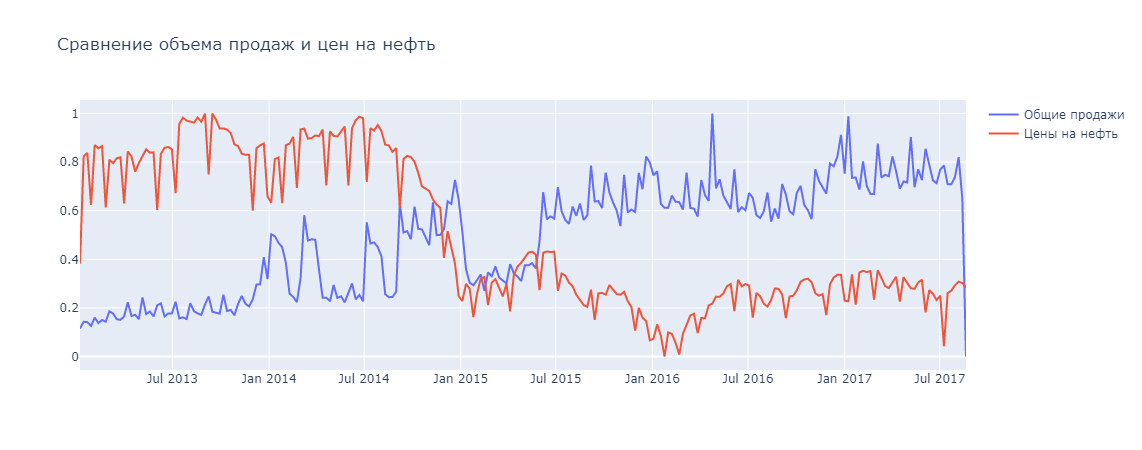

In [5]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=sales_and_prices['date'], y=sales_and_prices['sales'],
                    mode='lines',
                    name='Общие продажи'))
                    
fig.add_trace(go.Scatter(x=sales_and_prices['date'], y=sales_and_prices['oil_prices'],
                    mode='lines',
                    name='Цены на нефть'))

fig.update_layout(title_text='Сравнение объема продаж и цен на нефть')

fig.show()

display(Image(filename='img/sales_oil_prices.png', width=1200))

По данным графикам сложно определить, существует ли какая-либо зависимость между ппризнаками.

Узнаем, есть ли в данных корреляции. Будем использовать суммарные значения в каждый день. Возьмем данные с шагом 10 дней, 20 дней и 30 дней.

In [6]:
total_sales_resampled = total_sales.resample('1D').sum().interpolate()
total_sales_resampled = scale_series(total_sales_resampled)
total_sales_resampled = pd.DataFrame(total_sales_resampled).reset_index().rename(columns={0: 'sales'})

oil_prices_resampled = oil_prices.resample('1D').sum().interpolate()
oil_prices_resampled = scale_series(oil_prices_resampled)
oil_prices_resampled = pd.DataFrame(oil_prices_resampled).reset_index().rename(columns={0: 'oil_prices'})

sales_and_prices = total_sales_resampled.merge(oil_prices_resampled, how='left')

In [7]:
corr_coef = []
p_values = []

start = 0
stop = 10
step = 10

corr_rows_count = int(len(sales_and_prices.index) / step)

for i in range(corr_rows_count):
    coef, p_val = list(pearsonr(sales_and_prices.iloc[start:stop]['sales'], sales_and_prices.iloc[start:stop]['oil_prices']))
    corr_coef.append(coef)
    p_values.append(p_val)
    start = stop
    stop += step

correlations_10_days = pd.DataFrame(data={'corr': corr_coef, 'p_val': p_values})

correlations_10_days_not_significant = correlations_10_days[correlations_10_days['p_val'] > 0.05]

Красными кругами отметим на графиках не значимые корреляции (p-value > 0.05).

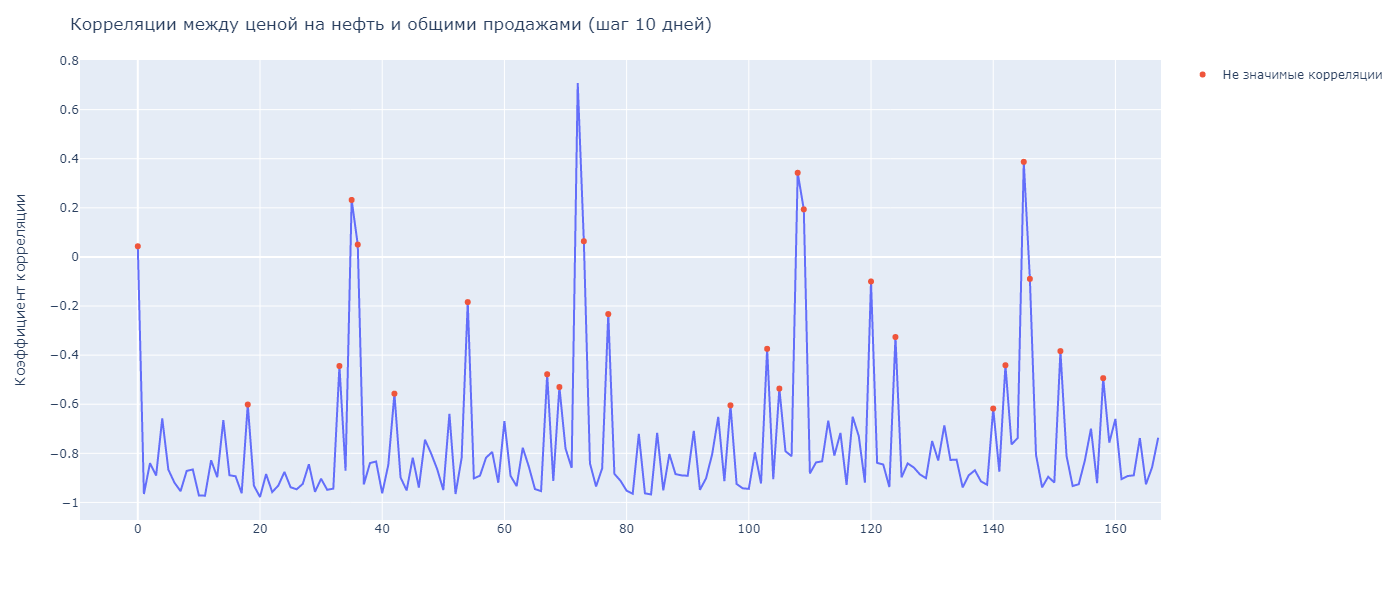

In [8]:
fig = px.line(correlations_10_days, x=range(168), y='corr', labels={'x': '', 'corr': 'Коэффициент корреляции'})

fig.add_trace(go.Scatter(x=list(correlations_10_days_not_significant.index),
                    y=correlations_10_days_not_significant['corr'],
                    mode='markers',
                    name='Не значимые корреляции'))

fig.update_layout(
    autosize=False,
    width=1400,
    height=600,
    title_text='Корреляции между ценой на нефть и общими продажами (шаг 10 дней)'
)

fig.show()

display(Image(filename='img/oil_sales_10day_corr.png', width=1200))

In [9]:
corr_coef = []
p_values = []

start = 0
stop = 20
step = 20

corr_rows_count = int(len(sales_and_prices.index) / step)

for i in range(corr_rows_count):
    coef, p_val = list(pearsonr(sales_and_prices.iloc[start:stop]['sales'], sales_and_prices.iloc[start:stop]['oil_prices']))
    corr_coef.append(coef)
    p_values.append(p_val)
    start = stop
    stop += step

correlations_20_days = pd.DataFrame(data={'corr': corr_coef, 'p_val': p_values})

correlations_20_days_not_significant = correlations_20_days[correlations_20_days['p_val'] > 0.05]

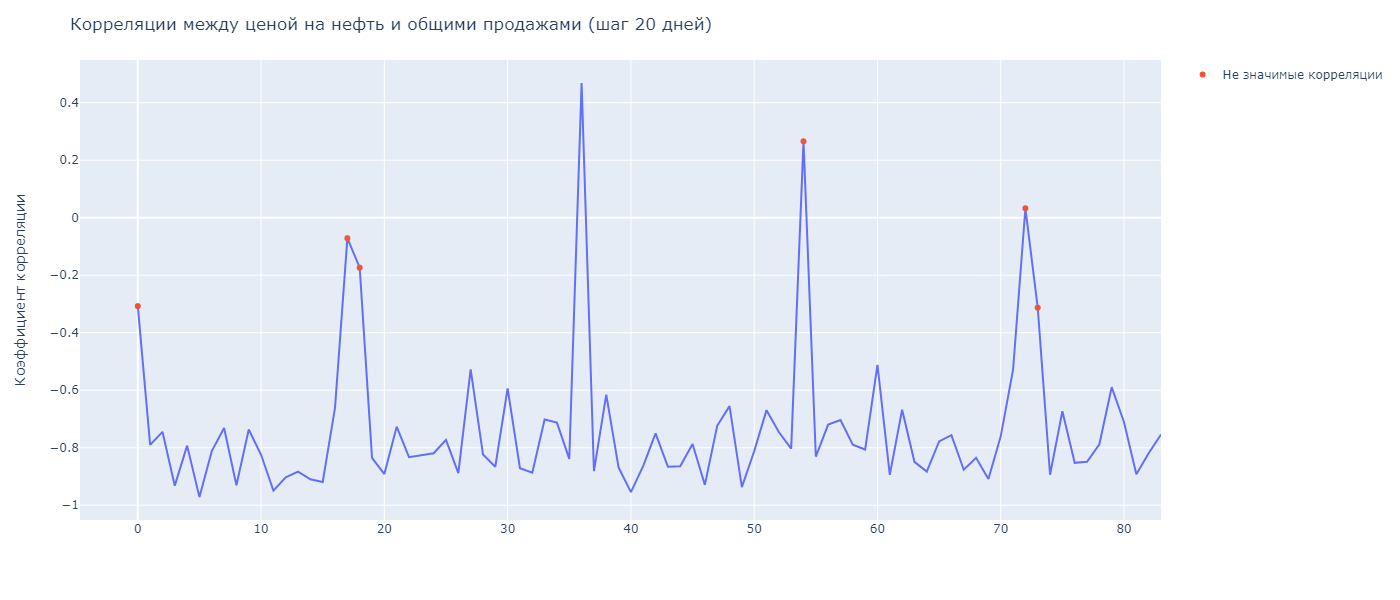

In [10]:
fig = px.line(correlations_20_days, x=range(84), y='corr', labels={'x': '', 'corr': 'Коэффициент корреляции'})

fig.add_trace(go.Scatter(x=list(correlations_20_days_not_significant.index),
                    y=correlations_20_days_not_significant['corr'],
                    mode='markers',
                    name='Не значимые корреляции'))

fig.update_layout(
    autosize=False,
    width=1400,
    height=600,
    title_text='Корреляции между ценой на нефть и общими продажами (шаг 20 дней)'
)

fig.show()

display(Image(filename='img/oil_sales_20day_corr.png', width=1200))

In [11]:
corr_coef = []
p_values = []

start = 0
stop = 30
step = 30

corr_rows_count = int(len(sales_and_prices.index) / step)

for i in range(corr_rows_count):
    coef, p_val = list(pearsonr(sales_and_prices.iloc[start:stop]['sales'], sales_and_prices.iloc[start:stop]['oil_prices']))
    corr_coef.append(coef)
    p_values.append(p_val)
    start = stop
    stop += step

correlations_30_days = pd.DataFrame(data={'corr': corr_coef, 'p_val': p_values})

correlations_30_days_not_significant = correlations_30_days[correlations_30_days['p_val'] > 0.05]

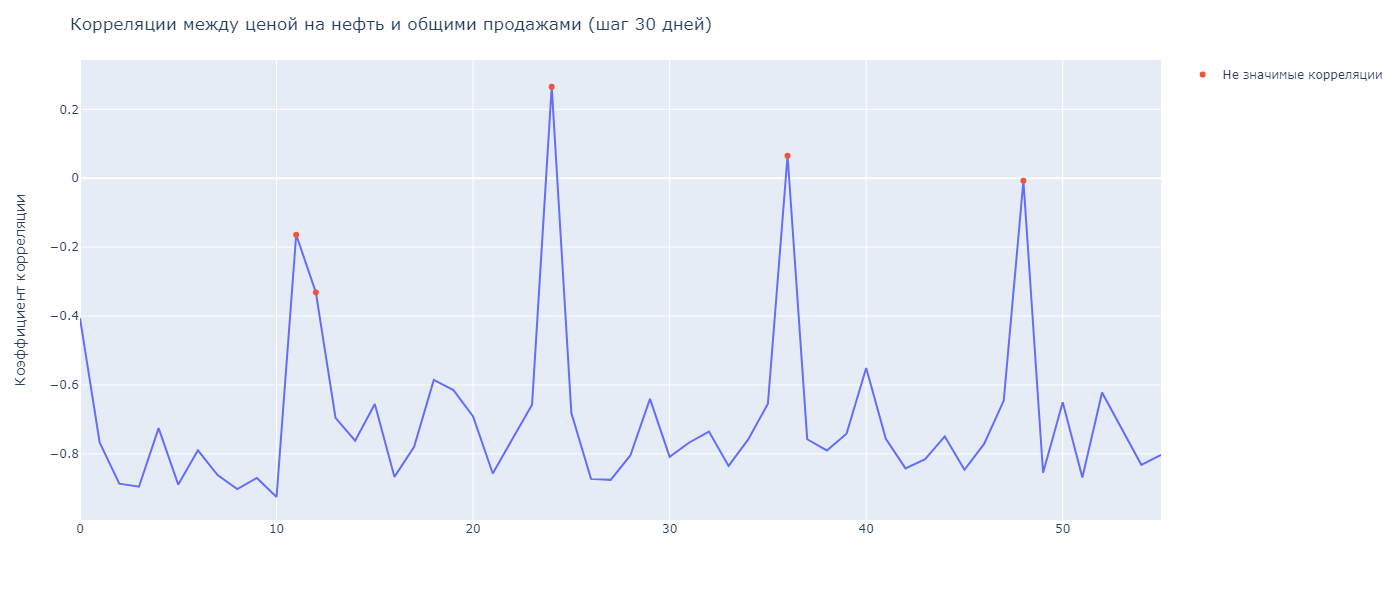

In [12]:
fig = px.line(correlations_30_days, x=range(56), y='corr', labels={'x': '', 'corr': 'Коэффициент корреляции'})

fig.add_trace(go.Scatter(x=list(correlations_30_days_not_significant.index),
                    y=correlations_30_days_not_significant['corr'],
                    mode='markers',
                    name='Не значимые корреляции'))

fig.update_layout(
    autosize=False,
    width=1400,
    height=600,
    title_text='Корреляции между ценой на нефть и общими продажами (шаг 30 дней)'
)

fig.show()

display(Image(filename='img/oil_sales_30day_corr.png', width=1200))

Во всех трех случаях (шаг 10, 20 и 30 дней) большинство значений лежит в промежутке от -0.8 до -1. Это значит, что в данных есть отрицательная корреляция.